In [1]:

import numpy as np
import pandas as pd 
import cv2
import os
import subprocess
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import Levenshtein

### Загружаем данные 
train.csv и val.csv имеют вид

`img_name,text`

`511192609_2.jpg,109.0`

то есть два столбца (название фото и цена на нем (с точкой и 0, которые надо будетт удалить))


In [3]:
def load_data(data_dir, train_csv_file, val_csv_file):
    # train.csv
    train_df = pd.read_csv(train_csv_file)
    train_df['text'] = train_df['text'].apply(lambda x: str(int(x)))  # убираем .0 и преобразуем в строку

    # val.csv
    val_df = pd.read_csv(val_csv_file)
    val_df['text'] = val_df['text'].apply(lambda x: str(int(x)))  # убираем .0 и преобразуем в строку

    train_image_names = set(train_df['img_name'].values)
    train_images = sorted([str(img) for img in data_dir.glob("*.jpg") if os.path.basename(img) in train_image_names])
    train_labels = [train_df.loc[train_df['img_name'] == os.path.basename(img), 'text'].values[0] for img in train_images]

    val_image_names = set(val_df['img_name'].values)
    val_images = sorted([str(img) for img in data_dir.glob("*.jpg") if os.path.basename(img) in val_image_names])
    val_labels = [val_df.loc[val_df['img_name'] == os.path.basename(img), 'text'].values[0] for img in val_images]

    return train_images, train_labels, val_images, val_labels


In [4]:
data_dir = Path("ocr_data/imgs/")
train_csv_file = "ocr_data/train.csv"
val_csv_file = "ocr_data/val.csv"
train_images, train_labels, val_images, val_labels = load_data(data_dir, train_csv_file, val_csv_file)


print("Количество изображений для обучения: ", len(train_images))
print("Количество меток для обучения: ", len(train_labels))
print("Количество изображений для валидации: ", len(val_images))
print("Количество меток для валидации: ", len(val_labels))

Количество изображений для обучения:  4952
Количество меток для обучения:  4952
Количество изображений для валидации:  1000
Количество меток для валидации:  1000


будем преобразовывать все фото к такому размеру

In [5]:
img_width = 64
img_height = 32

In [6]:
def process_image(img, img_size):
    # создаём целевое изображение и копируем в него исходное изображение
    new_w, new_h = img_size  # размеры целевого изображения
    height, width = img.shape  
    
    # коэффиценты масштабирования, выбираем максимальный и масштабируем изображение
    factor_x = width / new_w  
    factor_y = height / new_h 
    factor = max(factor_x, factor_y)  
    new_size = (min(new_w, int(width / factor)), min(new_h, int(height / factor)))

    img = cv2.resize(img, new_size)  
    
    target = np.ones(shape=(new_h, new_w), dtype='uint8') * 255  # пустое белое изображение
    target[0:new_size[1], 0:new_size[0]] = img  # вставляем масштабированное изображение в целевое
    img = cv2.transpose(target)
    
    return img  

преобразование тренировочных  и валидационных данных (читаем как черно-белые, обрабатываем и нормализуем)

In [7]:
def prepare_data(image_paths, labels, img_width, img_height):
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = process_image(image, (img_width, img_height))  
        image = image / 255.0
        images.append(image)
    
    images = np.array(images).reshape(-1, img_width, img_height, 1)
    return images, labels

Размер train_x (4952, 64, 32, 1)
Размер valid_x.shape (1000, 64, 32, 1)
Пример изображений:


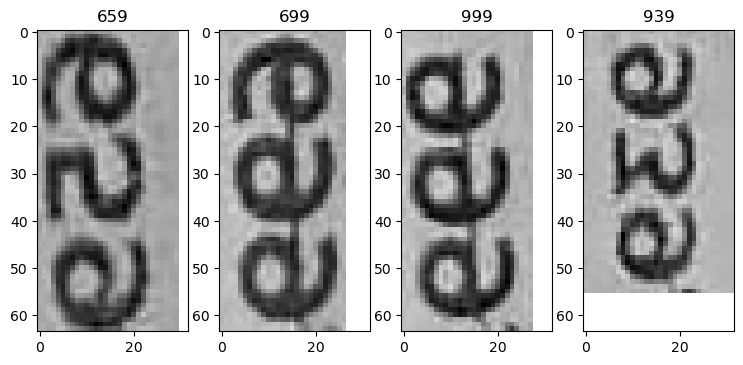

In [8]:
train_x, labels_train = prepare_data(train_images, train_labels, img_width, img_height)
valid_x, labels_valid = prepare_data(val_images, val_labels, img_width, img_height)


print('Размер train_x', train_x.shape)
print('Размер valid_x.shape', valid_x.shape)
print('Пример изображений:',)
plt.figure(num='multi digit', figsize=(9, 18))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    plt.title(labels_valid[i])
    plt.imshow(np.squeeze(valid_x[i, :, :, 0]), cmap='gray')
plt.show()


Неизвестно, какая наибольшая длина последовательно цифр 

Будем считать, что не больше миллиарда(9 нулей), так как рассматриваем цены, поэтому максимальная длина последовательности будет 10 

In [37]:
digits = u"0123456789' "
max_str_len = 10 

In [10]:
train_size =  4952
valid_size = 1000

-  train_y — это истинные метки, которые были преобразованы в числовой формат, недостающие символы заполняются значением -1. Длина каждой метки соответствует максимальной длине строки (то есть 10)
- train_input_len — это массив, который содержит длину каждой предсказанной метки, длина всех предсказанных строк будет одинаковой и равной числу временных меток (16-2=14), тк в CTC обычно первые два временных шага — это "мусор" 
- train_output — это фиктивный выход для вычисления CTC потерь (CTC работает с вероятностями для каждого возможного символа на каждом временном шаге)
- train_labels_l и valid_labels_l: одномерные массивы, которые будут хранить длину каждой метки в обучающем и валидационном наборах( массив, который содержит длину каждой истинной метки без учета паддинга)

In [11]:
def process_data(data_size, labels, max_str_len, timest_num=16):
    y = np.zeros([data_size, max_str_len]) -1
    labels_l = np.zeros([data_size, 1])
    input_len = np.ones([data_size, 1]) * (timest_num - 2)
    output = np.zeros([data_size])

    for i in range(data_size):
        labels_l[i] = len(labels[i])
        y[i, 0:len(labels[i])] = np.array([digits.find(ch) for ch in labels[i]])
    
    return y, labels_l, input_len, output

train_y, train_labels_l, train_input_len, train_output = process_data(train_size, labels_train, max_str_len)
valid_y, valid_labels_l, valid_input_len, valid_output = process_data(valid_size, labels_valid, max_str_len)

Для 799 y будет иметь вид [ 7.  9.  9. -1. -1. -1. -1. -1. -1. -1.]

## Создаем и обучаем модель

In [32]:
def create_crnn_model(img_width=64, img_height=32, max_str_len=10):  
    input_img = layers.Input(
        shape=(img_width, img_height, 1),  
        name="image",  
        dtype="float32"  
    )
    
    # первый сверточный блок
    x = layers.Conv2D(
        32,  # кол-во фильтров
        (3, 3),  # их размер
               activation="relu", 
        kernel_initializer="he_normal",  
        padding="same",  # доп нули по краям
        name="convolution_1" 
    )(input_img)
    
    # x = layers.BatchNormalization()(x) 
    # x = layers.ReLU()(x)  
    x = layers.MaxPooling2D((2, 2), name="max_pooling_1")(x)  

    # второй сверточный блок
    x = layers.Conv2D(
        64,  # кол-во фильтров
        (3, 3),  # их размер
        activation="relu", 
        kernel_initializer="he_normal",  
        padding="same",  # доп нули по краям
        name="convolution_2" 
    )(x)
    
    # x = layers.BatchNormalization()(x)
    # x = layers.ReLU()(x)  
    x = layers.MaxPooling2D((2, 2), name="max_pooling_2")(x)  


    # MaxPooling2D((2, 2) 2 раза =>размер уменьшился в 4 раза
    new_shape = ((img_width // 4), (img_height // 4) * 64)  
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)  
    x = layers.Dense(64, activation="relu", name="dense_1")(x)  
    x = layers.Dropout(0.2)(x)  

    # RNN
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)  
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)  

    y_pred = layers.Dense(11, activation="softmax", name="dense2")(x)  # прогноз для каждого символа
    model = keras.models.Model(inputs=input_img, outputs=y_pred, name="model")

    # функция потерь для CTC 
    def ctc_lambda_func(args):
        y_pred, labels, input_length, labels_l = args
        # первые 2 выхода RNN могут быть мусором
        y_pred = y_pred[:, 2:, :]  
        return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, labels_l) 


    labels = layers.Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')  # истинные метки
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')  # длина входных последовательностей
    labels_l = layers.Input(name='labels_l', shape=[1], dtype='int64')  # длина меток

    # слой CTC
    ctc_loss = keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, labels_l])
    model_final = keras.models.Model(inputs=[input_img, labels, input_length, labels_l], outputs=ctc_loss, name="price_model")
    
    return model, model_final  

In [33]:
model, model_final = create_crnn_model(img_width=64, img_height=32)
model.summary()  # инфо о модели без CTC
model_final.summary()  # инфо о модели с CTC

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_1 (Conv2D)          │ (None, 64, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 32, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_2 (Conv2D)          │ (None, 32, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 16, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 16, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 16, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 16, 11)         │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,051 (1.58 MB)

 Trainable params: 415,051 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

Model: "price_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 64, 32, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolution_1       │ (None, 64, 32,    │        320 │ image[0][0]       │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling_1       │ (None, 32, 16,    │          0 │ convolution_1[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolution_2       │ (None, 32, 16,    │     18,496 │ max_pooling_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling_2       │ (None, 16, 8, 64) │          0 │ convolution_2[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 16, 512)   │          0 │ max_pooling_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 64)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 16, 256)   │    197,632 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 16, 128)   │    164,352 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 16, 11)    │      1,419 │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gtruth_labels       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labels_l            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc (Lambda)        │ (None, 1)         │          0 │ dense2[0][0],     │
│                     │                   │            │ gtruth_labels[0]… │
│                     │                   │            │ input_length[0][… │
│                     │                   │            │ labels_l[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 415,051 (1.58 MB)

 Trainable params: 415,051 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("train_input_len shape:", train_input_len.shape)
print("train_labels_l shape:", train_labels_l.shape)

train_x shape: (4952, 64, 32, 1)
train_y shape: (4952, 10)
train_input_len shape: (4952, 1)
train_labels_l shape: (4952, 1)


In [35]:
# opt = keras.optimizers.Adam(learning_rate=0.001)
# opt = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
                    optimizer=opt)

model_final.fit(x=[train_x, train_y, train_input_len, train_labels_l],
                y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_labels_l], valid_output),
                epochs=200, 
                batch_size=32)


Epoch 1/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - loss: 7.3467 - val_loss: 6.0426
Epoch 2/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 5.7679 - val_loss: 4.0215
Epoch 3/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 3.9218 - val_loss: 1.8496
Epoch 4/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - loss: 1.9058 - val_loss: 1.2328
Epoch 5/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - loss: 0.9764 - val_loss: 0.7207
Epoch 6/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - loss: 0.6860 - val_loss: 0.4031
Epoch 7/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - loss: 0.5991 - val_loss: 0.4182
Epoch 8/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.4099 - val_loss: 0.3598
Epoch 9/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - loss: 0.3407 - val_loss: 0.2915
Epoch 10/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - loss: 0.2687 - val_loss: 0.2859
Epoch 11/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - loss: 0.2869 - val_loss: 0.2994
Epoch 12/200
155/15

In [39]:

model.save('res_model.keras')


## Оцениваем на валидационном датасете

Посчитаем метрики accuracy и CER

$CER = \frac{S + D + I}{N}$

- $ S $ — количество замен
- $ D $ — количество удалений
- $ I $ — количество вставок
- $ N $ — общее количество символов в истинных метках


In [38]:
def decode_output(num):
    return ''.join(digits[ch] for ch in num if ch != -1)

def cer(pred, ground_truth):
    t_chars = 0
    t_errors = 0
    
    for pr, tr in zip(pred, ground_truth):
        t_chars += len(tr)
        t_errors += Levenshtein.distance(pr, tr)  # расстояние Левенштейна (дает количество ошибок)
        
    cer_value = t_errors / t_chars  # ошибки / общее количество символов
    return cer_value


preds = model.predict(valid_x)
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, 
                                                                 input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                                                 greedy=True)[0][0])


prediction = [decode_output(decoded[i]) for i in range(valid_size)] # получаем предсказания
y_true = labels_valid

cer_value = cer(prediction, y_true)
print(f'CER: {cer_value * 100:.2f}%')


# количество правильных символов и общее количество символов
correct_digit = np.sum([sum([1 for pr_char, tr_char in zip(pr, tr) if pr_char == tr_char]) for pr, tr in zip(prediction, y_true)])
t_sum = np.sum([len(tr) for tr in y_true]) 

correct = np.sum([pr == tr for pr, tr in zip(prediction, y_true)]) # количество правильных чисел


print(f'Верно угадано цифр: {correct_digit * 100 / t_sum:.4f}%')
print(f'Верно угадано чисел (accuracy): {correct * 100 / valid_size:.1f}%')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
CER: 2.98%
Верно угадано цифр: 95.1654%
Верно угадано чисел (accuracy): 93.1%


### Accuracy 93.1%
### CER 2.98%


## Предсказания на test.csv
загружаем и получаем предсказания аналогично тренировочным и валидационным данным

In [21]:
test_df = pd.read_csv('ocr_data/test.csv')
test_image_names = set(test_df['img_name'].values)
test_images = sorted([str(img) for img in data_dir.glob("*.jpg") if os.path.basename(img) in test_image_names])

test_x = []
image_names = []  

for image_path in test_images:
    image_name = os.path.basename(image_path)  
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    image = process_image(image, (img_width, img_height)) 
    image = image / 255.  
    test_x.append(image)
    image_names.append(image_name) 

test_x = np.array(test_x).reshape(-1, img_width, img_height, 1)

preds = model.predict(test_x)
decoded = tf.keras.backend.get_value(
    tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0]) * preds.shape[1], greedy=True)[0][0]
)
predictions = [decode_output(decoded[i]) for i in range(len(decoded))]

df = pd.DataFrame({
    'img_name': image_names,
    'predicted_text': predictions
})

df.to_csv("test_predictions.csv", index=False)